# Computation

We should minimize the amount of smoothing done client-side in D3, since this is harder to control and we probably have fewer options. We should precompute, for each country-year.
- Lorenz on a standard grid (0.0, 1.0, 1000 steps).
- CDF on a set of standard linear grids (0, 10000, 1000 steps) or (0, 100000, 1000 steps)
- CDF on a standard log grid (0, 100000, 1000 steps)
- PDF of a set of standard linear grids as CDF
    - smoothed version of same
- PDF on a standard log grid (log(1)=0, log(100000)=5, 1000 steps)
    - smoothed version of same
    

In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import glob
import json

import numpy as np
import pandas as pd
import scipy.interpolate

import wbdata
import datetime

DAYS_PER_MONTH = 365.0/12.0

def coarsen(df, points, maintain_endpoints = True):
    nrows = max(df.count(0))
    stepsize = max(int(nrows/points),1)
    out = df.copy().iloc[::stepsize,:]
    
    # If we should maintain the endpoints, substitute the last regular point for the endpoint
    # (may be the same point if we're lucky)
    if maintain_endpoints:
        out = out[0:-1].append(df.tail(1))
    return out

def lag0(x, lags=1):
    return x.shift(lags).fillna(0)

def lorenz_to_cdf_cubic(L, mean, minimum, maximum, derive_bounds = False):
    dL = (L.L - lag0(L.L)) / (L.p - lag0(L.p))
    y = mean * dL
    p = (L.p + lag0(L.p))/2
    if minimum:
        y = np.hstack((minimum, y))
        p = np.hstack((0.0,p))
    if maximum:
        y = np.hstack((y, maximum))
        p = np.hstack((p,1.0))
    #print(np.vstack((y, p)))
    cdf = scipy.interpolate.CubicSpline(y, p, bc_type="clamped", extrapolate=0)#((2,0.0),(1, 0.0)), extrapolate=0)
    #cdf = scipy.interpolate.PchipInterpolator(y, p, extrapolate=False)
    minimum = mean * float(dL.head(1))
    maximum = mean * float(dL.tail(1))
    
    if derive_bounds:
        return cdf, (minimum, maximum)
    else:
        return cdf
    
def lorenz_cubic(L, minimum=0, maximum=1e4):
    Lc = scipy.interpolate.CubicSpline(
        np.hstack((0, L.p)),
        np.hstack((0, L.L)),
        bc_type=((2, 0),(2, 0)),
        extrapolate=0)
    return Lc


def inverse_of_scalar(f, x, a=1e-6, b=1-1e-6):
    try:
        return scipy.optimize.brentq(lambda y: f(y)-x, a, b)
    except ValueError:
        return float("NaN")

inverse_of = np.vectorize(inverse_of_scalar, excluded=('f','a','b'))

class IncomeDistribution(object):
    def __init__(self, raw_json_fn):
        with open(raw_json_fn) as f:
            self.data = json.load(f)
            
        self.cc3 = self.data['dataset']['cc3']
        self.year = self.data['dataset']['year']
        self.mean_ppp_day = self.data['summary']['mean_ppp'] / DAYS_PER_MONTH
        self.min_ppp_day = self.data['pop']['min'] / DAYS_PER_MONTH if 'pop' in self.data else None
        self.max_ppp_day = self.data['pop']['max'] / DAYS_PER_MONTH if 'pop' in self.data else None
        self.lorenz = pd.DataFrame(self.data['distribution'], index=None)
        self.init_interpolation()
        self.fetch_wdi_data()

    def init_interpolation(self):
        # Empirical CDF & PDF
        self.cdf, (self.min_ppp_day, self_max_ppp_day) = lorenz_to_cdf_cubic(self.lorenz, self.mean_ppp_day, self.min_ppp_day, self.max_ppp_day, True)
        self.pdf = self.cdf.derivative()
        
        # Smoothed (coarsened) CDF & PDF
        self.lorenz_smooth = coarsen(self.lorenz, 15)
        self.cdf_smooth = lorenz_to_cdf_cubic(self.lorenz_smooth, self.mean_ppp_day,  None, None)
        self.pdf_smooth = self.cdf_smooth.derivative()
        
    def fetch_wdi_data(self):
        self.population = float(wbdata.get_data(
            country = self.cc3,
            data_date = datetime.datetime(self.year, 1, 1),
            indicator = "SP.POP.TOTL"
        )[0]['value'])
        
        self.region_wb = wbdata.get_country(country_id = self.cc3, display=False)[0]['region']['id']

    def save_computed_json(self, out_json_fn):
        grid = np.arange(self.min_ppp_day, self.max_ppp_day, 0.1)
        gridlist = grid.tolist()
        
        out_json = {
            #'cdf': { 'x': self.cdf.x.tolist(), 'c': self.cdf.c.tolist() },
            'cdf_smooth': { 'x': self.cdf_smooth.x.tolist(), 'c': self.cdf_smooth.c.T.tolist() },
        }
        with open(out_json_fn, 'w') as f:
            json.dump(out_json, f)
            
    def pdf_smooth_semilog(self, y):
        return y*self.pdf_smooth(y)
    
    def pdf_semilog(self, y):
        return y*self.pdf(y)
    
class LorenzIncomeDistribution(IncomeDistribution):
    def __init__(self, raw_json_fn):
        super().__init__(raw_json_fn)
        
    def init_interpolation(self):
        rel_min = self.min_ppp_day / self.mean_ppp_day if self.min_ppp_day else None
        rel_max = self.max_ppp_day / self.mean_ppp_day if self.max_ppp_day else None
        
        # Empirical CDF & PDF
        self.Lc = lorenz_cubic(self.lorenz, rel_min, rel_max)
        self.cdf_inv = lambda p: self.mean_ppp_day * scipy.misc.derivative(self.Lc, p, dx=1e-6) 
        self.cdf = lambda y: inverse_of(self.cdf_inv, y)
        self.pdf = lambda y: scipy.misc.derivative(self.cdf, y, dx=1e-6)
        
        # Smoothed (coarsened) CDF & PDF
        self.lorenz_smooth = coarsen(self.lorenz, 15)
        self.Lc_smooth = lorenz_cubic(self.lorenz_smooth, rel_min, rel_max)
        self.cdf_inv_smooth = lambda p: self.mean_ppp_day * scipy.misc.derivative(self.Lc_smooth, p, dx=1e-6) 
        self.cdf_smooth = lambda y: inverse_of(self.cdf_inv_smooth, y)
        self.pdf_smooth = lambda y: scipy.misc.derivative(self.cdf_smooth, y, dx=1e-6)        
        
    def save_computed_json(self, out_json_fn):
        pass


In [3]:
d = dict()
for fn in glob.glob('../jsoncache/*.json'):
    #print(fn)
    try:
        survey = IncomeDistribution(fn)
        survey.save_computed_json('../computed/{}_{}.json'.format(survey.cc3, survey.year))
        if survey.cc3 not in d:
            d[survey.cc3] = dict()
        d[survey.cc3][survey.year] = survey
    except (ValueError, KeyError) as e:
        print(fn, e)

../jsoncache/AGO_2_2000.21.json `x` must be strictly increasing sequence.
../jsoncache/ARG_2_1992.json `x` must contain only finite values.
../jsoncache/ARG_2_1993.json `x` must contain only finite values.
../jsoncache/ARG_2_1994.json `x` must contain only finite values.
../jsoncache/ARG_2_1995.json `x` must contain only finite values.
../jsoncache/ARG_2_1996.json `x` must contain only finite values.
../jsoncache/ARG_2_1997.json `x` must contain only finite values.
../jsoncache/ARG_2_1998.json `x` must contain only finite values.
../jsoncache/ARG_2_1999.json `x` must contain only finite values.
../jsoncache/ARG_2_2000.json `x` must contain only finite values.
../jsoncache/ARG_2_2001.json `x` must contain only finite values.
../jsoncache/ARG_2_2002.json `x` must contain only finite values.
../jsoncache/ARG_2_2003.json `x` must contain only finite values.
../jsoncache/ARG_2_2007.json `x` must contain only finite values.
../jsoncache/AUS_3_1981.json `x` must be strictly increasing sequenc

In [4]:
d

{'AGO': {2008: <__main__.IncomeDistribution at 0x103d2f0f0>},
 'ALB': {1996: <__main__.IncomeDistribution at 0x106447d68>,
  2002: <__main__.IncomeDistribution at 0x1079f5358>,
  2005: <__main__.IncomeDistribution at 0x1078084e0>,
  2008: <__main__.IncomeDistribution at 0x107a34c50>,
  2012: <__main__.IncomeDistribution at 0x1064487f0>},
 'ARG': {1980: <__main__.IncomeDistribution at 0x107a44390>,
  1991: <__main__.IncomeDistribution at 0x107a4bf28>,
  2004: <__main__.IncomeDistribution at 0x107a4bac8>,
  2005: <__main__.IncomeDistribution at 0x107a5d630>,
  2006: <__main__.IncomeDistribution at 0x107a3b160>,
  2008: <__main__.IncomeDistribution at 0x107a5dfd0>,
  2009: <__main__.IncomeDistribution at 0x107a34a20>,
  2010: <__main__.IncomeDistribution at 0x107a34b00>,
  2011: <__main__.IncomeDistribution at 0x107a4bf60>,
  2012: <__main__.IncomeDistribution at 0x107a5dcf8>,
  2013: <__main__.IncomeDistribution at 0x107a63b38>,
  2014: <__main__.IncomeDistribution at 0x107a5de80>},
 'AR

In [33]:
#country_years = [('USA', 2010), ('GBR', 2010), ('AUS', 2010), ('MEX', 2010)]
latest_country_years = {cc3: max(d[cc3].keys()) for cc3 in d}
latest_country_years

{'AGO': 2008,
 'ALB': 2012,
 'ARG': 2014,
 'ARM': 2014,
 'AUS': 2010,
 'AUT': 2012,
 'AZE': 2008,
 'BDI': 2006,
 'BEL': 2012,
 'BEN': 2011,
 'BFA': 2014,
 'BGD': 2010,
 'BGR': 2012,
 'BIH': 2011,
 'BLR': 2012,
 'BLZ': 1999,
 'BOL': 2014,
 'BRA': 2012,
 'BTN': 2012,
 'BWA': 2009,
 'CAF': 2008,
 'CAN': 2010,
 'CHE': 2012,
 'CHL': 2013,
 'CHN': 2013,
 'CIV': 1995,
 'CMR': 2014,
 'COG': 2011,
 'COL': 2014,
 'COM': 2004,
 'CPV': 2007,
 'CRI': 2014,
 'CYP': 2012,
 'CZE': 2012,
 'DEU': 2011,
 'DJI': 2013,
 'DNK': 2012,
 'DOM': 2013,
 'ECU': 2014,
 'ESP': 2012,
 'EST': 2012,
 'ETH': 2010,
 'FIN': 2012,
 'FJI': 2008,
 'FRA': 2012,
 'FSM': 2013,
 'GAB': 2005,
 'GBR': 2012,
 'GEO': 2014,
 'GHA': 2005,
 'GIN': 2012,
 'GMB': 2003,
 'GNB': 2002,
 'GRC': 2012,
 'GTM': 2014,
 'HND': 2014,
 'HRV': 2012,
 'HTI': 2012,
 'HUN': 2012,
 'IDN': 2014,
 'IND': 2011,
 'IRL': 2012,
 'IRN': 2013,
 'ISL': 2012,
 'ISR': 2010,
 'ITA': 2012,
 'JAM': 2002,
 'JPN': 2008,
 'KAZ': 2013,
 'KEN': 2005,
 'KGZ': 2014,
 'KHM'

In [58]:
r = d['CHN'][2011]
pc = r.lorenz_smooth.p.as_matrix()
Lc = r.lorenz_smooth.L.as_matrix()
mean = r.mean_ppp_day

dL = np.diff(Lc)
dp = np.diff(pc)

pmid = np.hstack((0.0, np.add(pc[1:],pc[:-1])/2))

y = np.hstack((0.0, mean * dL/dp))
mean

4.710805479452055

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:23: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:26: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in double_scalars
/usr/local

-0.00519624314194 0.244601852609 0.942623505171 5.79607067719
(0.010570751711292474, 1.3252048097243678e-09)


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in power


TypeError: 'NoneType' object is not subscriptable

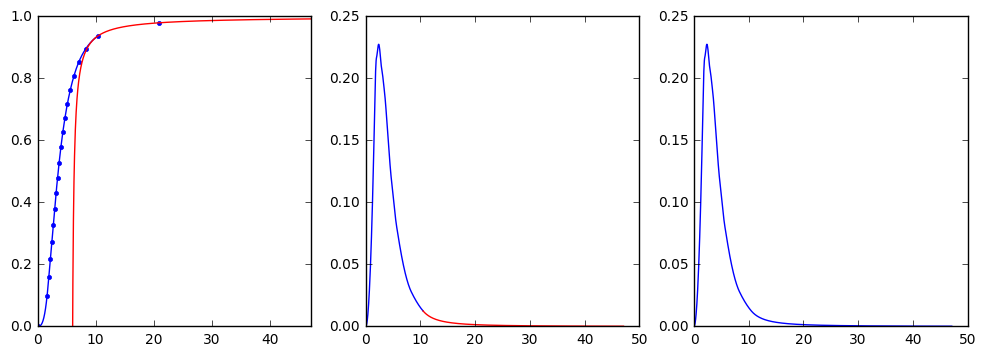

In [59]:


##########################################
plt.rcParams["figure.figsize"] = (12,4)
fig, ax = plt.subplots(1, 3)
##########################################

### F(x) = 1 - (x/xm)^a => solve for xm and a
p1 = pmid[-2]
y1 = y[-2]

p2 = pmid[-1]
y2 = y[-1]

#alpha = (np.log(1-p2) - np.log(1-p1)) / (np.log(y1) - np.log(y2))
#ym = np.exp(np.log(y2) + (1/alpha)*np.log(1-p2))
#yshift = 0

def pareto_cdf(y, ym, alpha, yshift):
    return 1 - (ym / (y - yshift))**alpha

def pareto_pdf(y, ym, alpha, yshift):
    return alpha * ym**alpha / (y - yshift)**(alpha+1)

def pareto_pdfderiv(y, ym, alpha, yshift):
    return -alpha*(alpha+1) * ym**alpha / (y - yshift)**(alpha+2)

def target(parameters):
    dd1, ym, alpha, yshift = parameters
    dd1 = dd1/100
    yshift = yshift*mean

    ccubpar_cdf = scipy.interpolate.CubicSpline(y[:-1], pmid[:-1], bc_type=((1, 0.0),(2,dd1)),extrapolate=0)
    ccubpar_pdf = ccubpar_cdf.derivative()

    err1 = pareto_cdf(y1, ym, alpha, yshift) - p1
    err1d = pareto_pdf(y1, ym, alpha, yshift) - ccubpar_pdf(y1)
    err1dd = pareto_pdfderiv(y1, ym, alpha, yshift) - ccubpar_pdf.derivative()(y1)
    #err1dd = 0
    err2 = pareto_cdf(y2, ym, alpha, yshift) - p2
    return err1**2 + (err1d*20)**2 + (err1dd*100)**2 + err2**2

from scipy.optimize import basinhopping
#guess = (-0.000015, 2.85446391657, 0.783499652638, 135.703869627)
guess = (0, 1, 1, 1)
dd1, ym, alpha, yshift = basinhopping(target, guess).x
dd1 = dd1/100
yshift = yshift*mean
print(dd1, ym, alpha, yshift)

ccubpar_cdf = scipy.interpolate.CubicSpline(y[:-1], pmid[:-1], bc_type=((1, 0.0),(2,dd1)),extrapolate=0)
ccubpar_pdf = ccubpar_cdf.derivative()
d1 = ccubpar_pdf(y1)
dd1 = ccubpar_pdf.derivative()(y1)

xgrid = np.linspace(0.0, 1.0, 1000)
ygrid = np.linspace(0.0, mean*10.0, 1000)

ax[0].plot(y, pmid, ".")
ax[0].plot(ygrid, ccubpar_cdf(ygrid), 'b-')
ax[1].plot(ygrid, ccubpar_pdf(ygrid), 'b-')

ax[0].plot(ygrid, pareto_cdf(ygrid, ym, alpha, yshift), 'r-')
ax[0].set_xlim((0,mean*10))
ax[0].set_ylim((0, 1.0))

ygrid2 = np.linspace(y1, mean*10, 1000)

ax[1].plot(ygrid2, pareto_pdf(ygrid2, ym, alpha, yshift), 'r-')

final_pdf = np.vectorize(lambda y: ccubpar_pdf(y) if y < y1 else pareto_pdf(y, ym, alpha, yshift))
ax[2].plot(ygrid, final_pdf(ygrid))
import scipy.integrate
print(scipy.integrate.quad(final_pdf, 35.15, 1e3))[0]

In [ ]:
dist = d['IND'][2011]
grid = np.arange(0,20,0.1)
#plt.plot(grid,dist.cdf(grid))
dist.cdf_inv(0.5)
#scipy.optimize.brentq(lambda x: dist.cdf_inv(x)-2.806, 1e3, 1-1e3)
inverse_of_scalar(dist.cdf_inv, 2.806)

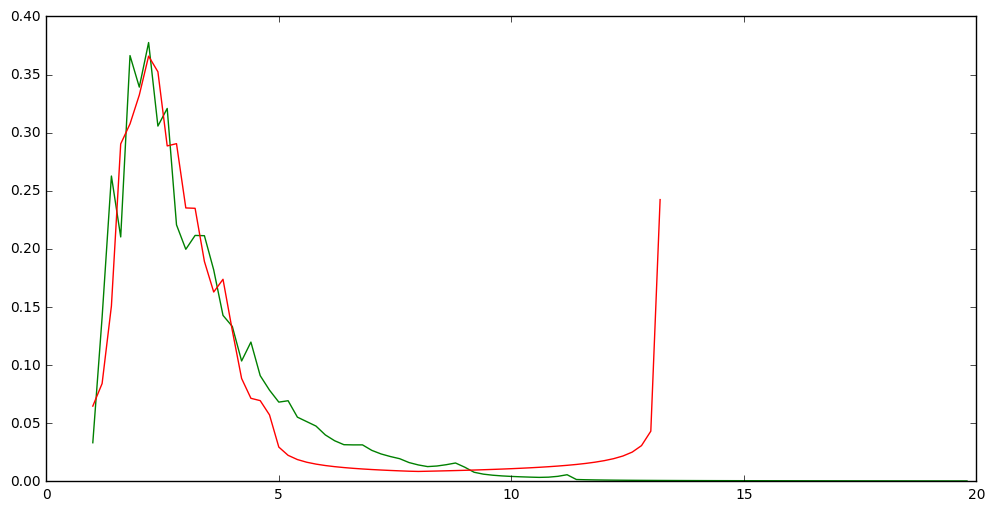

/usr/local/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


array(0.9416168749539245)

In [108]:
dist = d['IND'][2011]

grid = np.arange(0, 20, 0.2)

plt.rcParams["figure.figsize"] = (12,6)

plt.plot(grid,dist.pdf(grid),'g')
plt.plot(grid,dist.pdf_smooth(grid),'r')

plt.show()

import scipy.integrate
scipy.integrate.quad(dist.pdf, dist.min_ppp_day, dist.max_ppp_day)

#dist.lorenz_smooth

#plt.plot(dist.lorenz_smooth.p, dist.lorenz_smooth.L)
dist.max_ppp_day

dist.cdf_smooth(11)

In [109]:
for cc3, year in latest_country_years.items():
    if d[cc3][year].pdf(100) < 0:
        print(cc3, year, d[cc3][year].pdf(100))

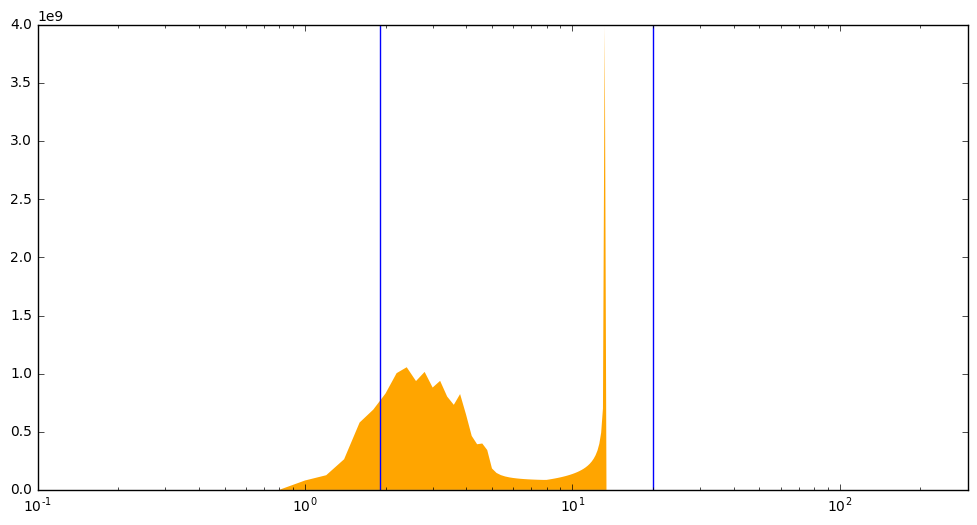

In [110]:
region_cols = {'EAS': 'red', 'ECS': 'blue', 'LCN': 'green', 'MEA': 'yellow', 'NAC': 'blue', 'SAS': 'orange', 'SSF': 'pink'}
region_sort = {'EAS': 7, 'ECS': 2, 'LCN': 4, 'MEA': 5, 'NAC': 1, 'SAS': 6, 'SSF': 3}
grid = np.arange(0,300,0.2)

stacks = sorted(latest_country_years.items(), key = lambda x: (region_sort[d[x[0]][x[1]].region_wb], d[x[0]][x[1]].population))
bigdf = np.row_stack([np.nan_to_num(d[cc3][year].population*d[cc3][year].pdf_smooth_semilog(grid)) for (cc3, year) in stacks])

ax = plt.subplot()
ax.set_xscale("log", nonposx='clip')
plt.xlim(0.1,300)
plt.stackplot(grid,bigdf,colors=[region_cols[d[cc3][year].region_wb] for (cc3, year) in stacks],edgecolor='none')
plt.axvline(1.90)
plt.axvline(20)
plt.show()

In [293]:
grid

array([  0. ,   0.2,   0.4,   0.6,   0.8,   1. ,   1.2,   1.4,   1.6,
         1.8,   2. ,   2.2,   2.4,   2.6,   2.8,   3. ,   3.2,   3.4,
         3.6,   3.8,   4. ,   4.2,   4.4,   4.6,   4.8,   5. ,   5.2,
         5.4,   5.6,   5.8,   6. ,   6.2,   6.4,   6.6,   6.8,   7. ,
         7.2,   7.4,   7.6,   7.8,   8. ,   8.2,   8.4,   8.6,   8.8,
         9. ,   9.2,   9.4,   9.6,   9.8,  10. ,  10.2,  10.4,  10.6,
        10.8,  11. ,  11.2,  11.4,  11.6,  11.8,  12. ,  12.2,  12.4,
        12.6,  12.8,  13. ,  13.2,  13.4,  13.6,  13.8,  14. ,  14.2,
        14.4,  14.6,  14.8,  15. ,  15.2,  15.4,  15.6,  15.8,  16. ,
        16.2,  16.4,  16.6,  16.8,  17. ,  17.2,  17.4,  17.6,  17.8,
        18. ,  18.2,  18.4,  18.6,  18.8,  19. ,  19.2,  19.4,  19.6,  19.8])

# Issues

- It seems like BRA 2010 is not a well-formed Lorenz curve, around 57,58 it is non-convex
- Some distributions are just noisy - e.g. GBR 2010 - these are messy to plot as distributions, better to plot as histograms?

## When plotting a density on a semilog (x) chart, need to rescale y to preserve integral

The maths is relatively straightforward. Ordinarily we are plotting $f(x)$ against $x$, but now we are plotting against $y = log_{10}(x)$. Then $x = 10^y$ and so by a change of variables, we are plotting $f(10^y)$ against $y$ (but labelled with $x$). Then we can use change of variables to write the integral as

$$\int_a^b f(x)\,dx = \int_{\log_{10}(a)}^{\log_{10}(b)} (\log 10) 10^y f(10^y)\,dy = K \int_{\log_{10}(a)}^{\log_{10}(b)} x f(x)\,dy $$

so that we need to rescale the y-values by x in order to preserve areas on a semilog chart. With this transformation, the appearance of shapes (e.g. symmetry) is not preserved and the y-axis becomes hard to interpret.

In [ ]:
%matplotlib notebook
from scipy.stats import uniform

x_axis = np.arange(0, 20, 0.01)
y1 = uniform.pdf(x_axis,1,1)
y2 = uniform.pdf(x_axis,10,1)
plt.plot(x_axis, y1)
plt.plot(x_axis, y2)


In [ ]:
plt.semilogx(x_axis, (x_axis)*y1)
plt.semilogx(x_axis, (x_axis)*y2)

In [ ]:
wbdata.search_indicators("electricity")